In [33]:

# yeni hali 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,  LSTM , BatchNormalization

from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector, Concatenate, Attention

from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler


In [34]:
import yfinance as yf

In [35]:
import os

if os.path.exists('datas'):
    #sil
    os.system('rm -rf datas')

In [36]:
#period = '3000d'
period = 'max'


#features = ['Open', 'High', 'Low', 'Close','Adj Close', 'Volume']
features = [ 'Close' ]  # Sadece kapanış fiyatını kullanın

#tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ADBE','BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD','BCH-USD', 'BNB-USD', 'LINK-USD', 'ADA-USD', 'XLM-USD', 'SOL-USD', 'TRX-USD']

#tickers = ['SOL-USD']

#tickers = ['BTC-USD']

tickers = ['BTC-USD' , 'SOL-USD'] # ilki yanlış ikinciyi doğru tahmin etti

#tickers = [  'SOL-USD', 'BTC-USD' , 'ETH-USD']









In [37]:
def indir_ve_df_olustur(tickers, period):
    # Her bir hisse senedi için boş bir sözlük oluşturun
    pariteler = {}

    # Her bir hisse senedi için döngü oluşturun ve verileri indirin
    for ticker in tickers:
        try:
            # Hisse senedi verilerini indirin
            veri = yf.download(ticker, period=period)

            veri = veri[features]   
            # Veriyi sözlüğe ekleyin
            pariteler[ticker] = veri
            
            
        except Exception as e:
            print(f"{ticker} için veri indirilirken bir hata oluştu: {str(e)}")

    # Her bir hisse senedi için ayrı bir veri çerçevesi oluşturun
    df_listesi = [veri for veri in pariteler.values()]

    return df_listesi

In [38]:
#pariteler adında klasör oluştur :

import os 

if not os.path.exists('datas/pariteler'):
    os.makedirs('datas/pariteler')



In [39]:
datasets = indir_ve_df_olustur(tickers, period)

#pariteler içine kaydet 

for i in range(len(datasets)):
    datasets[i].to_csv(f'datas/pariteler/{tickers[i]}.csv')
    print(f'{tickers[i]} verisi csv olarak kaydedildi')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
BTC-USD verisi csv olarak kaydedildi
SOL-USD verisi csv olarak kaydedildi


In [40]:
scaler  = MinMaxScaler()

#her bir veri çerçevesi için scaled dataset oluştur

if not os.path.exists('datas/scaled_datasets'):
    os.makedirs('datas/scaled_datasets')

scaled_datasets = []

for i in range(len(datasets)):
    scaled_datasets.append(scaler.fit_transform(datasets[i]))
    np.save(f'datas/scaled_datasets/{tickers[i]}.npy', scaled_datasets[i])
    print(f'{tickers[i]} verisi scaled edilerek kaydedildi')
    

BTC-USD verisi scaled edilerek kaydedildi
SOL-USD verisi scaled edilerek kaydedildi


In [41]:
# her bir veri çerçevesi için veriyi dizilere bölme

seq_length = 60  # Son 60 günü kullanarak
pred_length = 7  # Önümüzdeki 7 günü tahmin etme

def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data)-seq_length-pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

# her bir veri çerçevesi için veriyi dizilere bölme

if not os.path.exists('datas/sequences'):
    os.makedirs('datas/sequences')

X, y = [], []

for i in range(len(scaled_datasets)):
    X_, y_ = create_sequences(scaled_datasets[i], seq_length, pred_length)
    X.append(X_)
    y.append(y_)
    np.save(f'datas/sequences/X_{tickers[i]}.npy', X_)
    np.save(f'datas/sequences/y_{tickers[i]}.npy', y_)
    print(f'{tickers[i]} verisi dizilere bölünerek kaydedildi')
    


BTC-USD verisi dizilere bölünerek kaydedildi
SOL-USD verisi dizilere bölünerek kaydedildi


In [42]:
# her bir veri çerçevesi için  seq2seq attention modeli oluştur

# Encoder
encoder_inputs = Input(shape=(seq_length, len(features)))
encoder_lstm = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]


# Decoder
decoder_inputs = RepeatVector(pred_length)(encoder_outputs)
decoder_lstm = LSTM(100, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)


# Dikkat Mekanizması
attention_layer = Attention(use_scale=True)
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_outputs])


# TimeDistributed Dense
decoder_dense = TimeDistributed(Dense(len(features)))
decoder_outputs = decoder_dense(decoder_concat_input)

def create_model(encoder_inputs, decoder_outputs):
    model = Model(encoder_inputs, decoder_outputs)
    return model
    


In [43]:
# her bir veri çerçevesi için modeli oluştur ve eğit

if not os.path.exists('datas/models'):
    os.makedirs('datas/models')

models = []
batch_size = 64
epochs = 20

for i in range(len(scaled_datasets)):
    # modeli oluştur
    model = create_model(encoder_inputs, decoder_outputs)
    
    # modeli derle
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # modeli listeye ekle
    models.append(model)
    
    # modeli eğit
    models[i].fit(X[i], y[i],
                  batch_size=batch_size, epochs=epochs, 
                  validation_split=0.2, verbose=1)
    
    # modeli kaydet
    models[i].save(f'datas/models/{tickers[i]}_model.h5')
    
    # ağırlıkları kaydet
    models[i].save_weights(f'datas/models/{tickers[i]}_model_weights.h5')
    


    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')


Epoch 1/20


2024-02-08 04:33:39.444829: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


41/43 [===========================>..] - ETA: 0s - loss: 0.0092

2024-02-08 04:33:42.236877: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


43/43 [==============================] - 7s 60ms/step - loss: 0.0090 - val_loss: 0.0011
Epoch 2/20
43/43 [==============================] - 2s 36ms/step - loss: 9.5581e-04 - val_loss: 0.0010
Epoch 3/20
43/43 [==============================] - 2s 35ms/step - loss: 9.3691e-04 - val_loss: 0.0075
Epoch 4/20
43/43 [==============================] - 2s 36ms/step - loss: 0.0011 - val_loss: 7.9502e-04
Epoch 5/20
43/43 [==============================] - 2s 38ms/step - loss: 0.0012 - val_loss: 8.5678e-04
Epoch 6/20
43/43 [==============================] - 2s 36ms/step - loss: 7.8854e-04 - val_loss: 8.2294e-04
Epoch 7/20
43/43 [==============================] - 2s 35ms/step - loss: 7.4056e-04 - val_loss: 0.0017
Epoch 8/20
43/43 [==============================] - 2s 35ms/step - loss: 8.0407e-04 - val_loss: 0.0017
Epoch 9/20
43/43 [==============================] - 2s 36ms/step - loss: 7.5143e-04 - val_loss: 8.5501e-04
Epoch 10/20
43/43 [==============================] - 2s 36ms/step - loss: 7.8425

/Users/mustafakapici/anaconda3/envs/all/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-02-08 04:34:16.926324: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


17/17 [==============================] - 7s 106ms/step - loss: 0.0019 - val_loss: 5.7008e-04
Epoch 2/20


2024-02-08 04:34:18.981719: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


17/17 [==============================] - 1s 39ms/step - loss: 0.0016 - val_loss: 6.2911e-04
Epoch 3/20
17/17 [==============================] - 1s 42ms/step - loss: 0.0016 - val_loss: 5.6719e-04
Epoch 4/20
17/17 [==============================] - 1s 40ms/step - loss: 0.0016 - val_loss: 5.7532e-04
Epoch 5/20
17/17 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 5.2849e-04
Epoch 6/20
17/17 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 5.7037e-04
Epoch 7/20
17/17 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 6.3747e-04
Epoch 8/20
17/17 [==============================] - 1s 39ms/step - loss: 0.0016 - val_loss: 5.2463e-04
Epoch 9/20
17/17 [==============================] - 1s 40ms/step - loss: 0.0015 - val_loss: 6.1551e-04
Epoch 10/20
17/17 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 6.2083e-04
Epoch 11/20
17/17 [==============================] - 1s 39ms/step - loss: 0.0017 - 

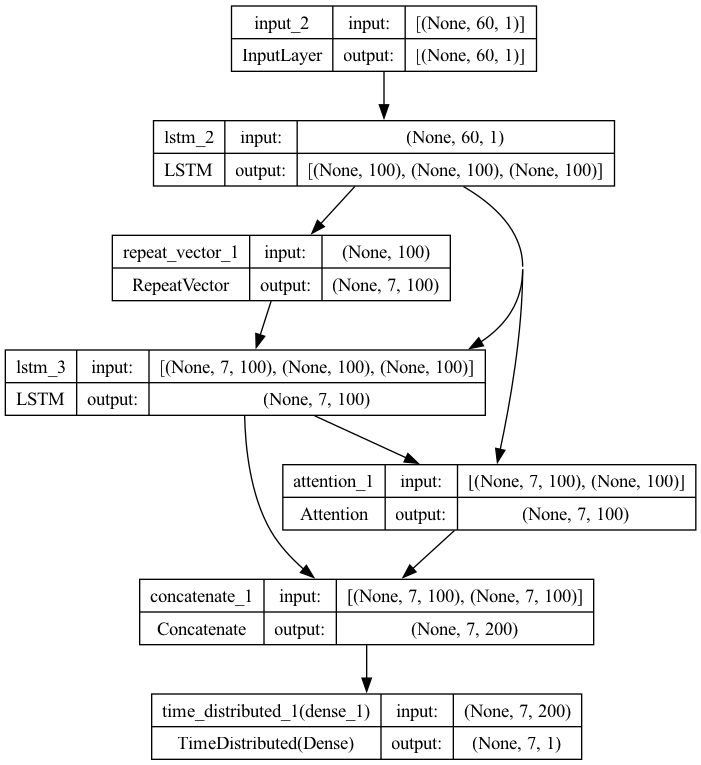

In [44]:
# modelerden bir tanesini png kaydedelim
from tensorflow.keras.utils import plot_model
plot_model(models[0], to_file='datas/model.png', show_shapes=True, show_layer_names=True , rankdir='TB', expand_nested=True, dpi=96, )

In [45]:
# her bir veri çerçevesi için last_sequence = data_scaled[-seq_length:] mantığında prediction yap

if not os.path.exists('datas/predictions'):
    os.makedirs('datas/predictions')
    
predictions = []    

for i in range(len(scaled_datasets)):
    last_sequence = scaled_datasets[i][-seq_length:]
    last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5', custom_objects={'Attention': Attention})
    
    predicted = model.predict(last_sequence)
    
    predictions.append(predicted)
    np.save(f'datas/predictions/{tickers[i]}_prediction.npy', predicted)
    print(f'{tickers[i]} verisi için prediction yapıldı ve kaydedildi')
    

1/1 [==============================] - 1s 1s/step


2024-02-08 04:34:33.979132: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


BTC-USD verisi için prediction yapıldı ve kaydedildi
1/1 [==============================] - 1s 1s/step
SOL-USD verisi için prediction yapıldı ve kaydedildi


2024-02-08 04:34:35.697520: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [46]:
# her bir veri çerçevesi için bütün sütunları predictionları geri dönüşüm yap ve yeni bi df e kaydet

if not os.path.exists('datas/forecasts'):
    os.makedirs('datas/forecasts')
    
forecasts = []

for i in range(len(scaled_datasets)):
    prediction = np.load(f'datas/predictions/{tickers[i]}_prediction.npy')
    
    #prediction = predictions[i]
    
    prediction = scaler.inverse_transform(prediction.reshape(-1, len(features) ))
    forecasts.append(prediction)
    np.save(f'datas/forecasts/{tickers[i]}_forecast.npy', prediction)
    print(f'{tickers[i]} verisi için forecast yapıldı ve kaydedildi')
    print(forecasts[i].shape)
    
# dataframe oluştur

for i in range(len(forecasts)):
    
    
    forecast = forecasts[i]
    forecast_dates = datasets[i].index[-pred_length:]
    forecast = pd.DataFrame(forecast, index=forecast_dates, columns=features)
    forecast.to_csv(f'datas/forecasts/{tickers[i]}_forecast.csv')
    print(f'{tickers[i]} verisi için forecast dataframe oluşturuldu ve kaydedildi')


    

BTC-USD verisi için forecast yapıldı ve kaydedildi
(7, 1)
SOL-USD verisi için forecast yapıldı ve kaydedildi
(7, 1)
BTC-USD verisi için forecast dataframe oluşturuldu ve kaydedildi
SOL-USD verisi için forecast dataframe oluşturuldu ve kaydedildi


In [47]:
#dataframeleri bi yazdır tarihleri ile

for i in range(len(forecasts)):
    forecast = pd.read_csv(f'datas/forecasts/{tickers[i]}_forecast.csv', index_col=0)
    print(f'{tickers[i]} verisi için forecast dataframe')
    print(forecast)

BTC-USD verisi için forecast dataframe
                Close
Date                 
2024-02-01  163.77681
2024-02-02  166.23352
2024-02-03  165.32108
2024-02-04  164.28748
2024-02-05  163.85931
2024-02-06  164.02556
2024-02-08  164.59490
SOL-USD verisi için forecast dataframe
                 Close
Date                  
2024-02-01   97.133020
2024-02-02  100.296170
2024-02-03  100.958310
2024-02-04  101.325035
2024-02-05  101.752210
2024-02-06  102.219610
2024-02-08  102.663240


In [48]:
# Gerçek veriyi yazdır aynı tarihteki 

for i in range(len(datasets)):
    print(f'{tickers[i]} verisi için gerçek veri')
    print(datasets[i].tail(pred_length))


BTC-USD verisi için gerçek veri
                   Close
Date                    
2024-02-01  43075.773438
2024-02-02  43185.859375
2024-02-03  42992.250000
2024-02-04  42583.582031
2024-02-05  42658.667969
2024-02-06  43084.671875
2024-02-08  44543.406250
SOL-USD verisi için gerçek veri
                 Close
Date                  
2024-02-01   97.846695
2024-02-02  100.440521
2024-02-03   97.879982
2024-02-04   95.476959
2024-02-05   95.548660
2024-02-06   96.861076
2024-02-08  101.563423


## 2. Kısım

In [49]:
# her bir veri çerçevesi için eğitime uygun full data hazırla (tensor dataset)

if not os.path.exists('datas/full_data'):
    os.makedirs('datas/full_data')
    
full_data = []

for i in range(len(scaled_datasets)):
    
    scaled_dataset_all = np.load(f'datas/scaled_datasets/{tickers[i]}.npy')
    
    #scaled_dataset_all = scaled_datasets[i].reshape(-1, len(features))
    
    scaled_dataset_all = tf.data.Dataset.from_tensor_slices(scaled_dataset_all)
    
    scaled_dataset_all = tf.data.Dataset.zip((scaled_dataset_all, scaled_dataset_all.skip(seq_length)))
    
    full_data.append(scaled_dataset_all)
    
    full_data[i] = full_data[i].batch(batch_size, drop_remainder=True).prefetch(1)
    
    full_data[i] = full_data[i].cache(f'datas/full_data/{tickers[i]}_full_data')

    print(f'{tickers[i]} verisi için full data hazırlandı')
    
    
    

BTC-USD verisi için full data hazırlandı
SOL-USD verisi için full data hazırlandı


In [50]:
# her bir veri çerçevesi için modeli import et ve eğit

for i in range(len(scaled_datasets)):
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5', custom_objects={'Attention': Attention})
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(full_data[i], epochs=epochs, verbose=1)
    
    model.save(f'datas/models/{tickers[i]}_model.h5')
    
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')
    

Epoch 1/20


2024-02-08 04:34:36.564274: W tensorflow/core/kernels/data/cache_dataset_ops.cc:298] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-08 04:34:40.888589: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype:

52/52 [==============================] - 5s 8ms/step - loss: 0.0201
Epoch 2/20
20/52 [==========>...................] - ETA: 0s - loss: 0.0123

2024-02-08 04:34:41.764847: W tensorflow/core/kernels/data/cache_dataset_ops.cc:298] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


52/52 [==============================] - 0s 9ms/step - loss: 0.0245
Epoch 3/20
52/52 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 4/20
52/52 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 5/20
52/52 [==============================] - 0s 9ms/step - loss: 0.0124
Epoch 6/20
52/52 [==============================] - 0s 9ms/step - loss: 0.0120
Epoch 7/20
52/52 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 8/20
52/52 [==============================] - 1s 10ms/step - loss: 0.0115
Epoch 9/20
52/52 [==============================] - 1s 10ms/step - loss: 0.0113
Epoch 10/20
52/52 [==============================] - 1s 10ms/step - loss: 0.0111
Epoch 11/20
52/52 [==============================] - 1s 10ms/step - loss: 0.0109
Epoch 12/20
52/52 [==============================] - 1s 10ms/step - loss: 0.0108
Epoch 13/20
52/52 [==============================] - 1s 11ms/step - loss: 0.0107
Epoch 14/20
52/52 [==============================] - 

/Users/mustafakapici/anaconda3/envs/all/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/20


2024-02-08 04:34:52.852691: W tensorflow/core/kernels/data/cache_dataset_ops.cc:298] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-08 04:34:58.337139: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype:

20/20 [==============================] - 6s 11ms/step - loss: 0.0254
Epoch 2/20
16/20 [=======================>......] - ETA: 0s - loss: 0.0275

2024-02-08 04:34:59.167691: W tensorflow/core/kernels/data/cache_dataset_ops.cc:298] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


20/20 [==============================] - 0s 11ms/step - loss: 0.0227
Epoch 3/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0225
Epoch 4/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0221
Epoch 5/20
20/20 [==============================] - 0s 10ms/step - loss: 0.0220
Epoch 6/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 7/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 8/20
20/20 [==============================] - 0s 12ms/step - loss: 0.0217
Epoch 9/20
20/20 [==============================] - 0s 12ms/step - loss: 0.0216
Epoch 10/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0215
Epoch 11/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0215
Epoch 12/20
20/20 [==============================] - 0s 12ms/step - loss: 0.0214
Epoch 13/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0214
Epoch 14/20
20/20 [============================

In [51]:
into_future = 1 # 7 gün için 1 hafta

def future_forecast(model, data, into_future):
    future_forecast = []
    last_sequence = data[-seq_length:]
    last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    for i in range(into_future):
        predicted = model.predict(last_sequence)
        future_forecast.append(predicted)
        last_sequence = np.append(last_sequence, predicted)
        last_sequence = last_sequence[-seq_length:]
        last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    return future_forecast


In [52]:
print( into_future , seq_length,)

1 60


In [53]:
future_values = []

if not os.path.exists('datas/future_values'):
    os.makedirs('datas/future_values')

for i in range(len(scaled_datasets)):
    future_values.append(future_forecast(models[i], scaled_datasets[i], into_future))
    np.save(f'datas/future_values/{tickers[i]}_future_values.npy', future_values[i])
    print(f'{tickers[i]} verisi için future values yapıldı ve kaydedildi')
    

2024-02-08 04:35:05.252593: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 2s 2s/step
BTC-USD verisi için future values yapıldı ve kaydedildi


2024-02-08 04:35:07.503405: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 2s 2s/step
SOL-USD verisi için future values yapıldı ve kaydedildi


In [54]:
# her bir veri çerçevesi için future valuesları geri dönüşüm yap ve yeni bi df e kaydet

if not os.path.exists('datas/future_forecasts'):
    os.makedirs('datas/future_forecasts')
    
future_forecasts = []

for i in range(len(scaled_datasets)):
    
    #np array olarak future values al
    future_value = np.load(f'datas/future_values/{tickers[i]}_future_values.npy')
    future_value = scaler.inverse_transform(future_value.reshape(-1, 1))
    future_forecasts.append(future_value)
    np.save(f'datas/future_forecasts/{tickers[i]}_future_forecast.npy', future_value)
    print(f'{tickers[i]} verisi için future forecast yapıldı ve kaydedildi')
    print(future_forecasts[i].shape)

BTC-USD verisi için future forecast yapıldı ve kaydedildi
(7, 1)
SOL-USD verisi için future forecast yapıldı ve kaydedildi
(7, 1)


In [55]:
print(future_forecasts[0])

[[165.8111 ]
 [166.7727 ]
 [165.90314]
 [165.27643]
 [165.06367]
 [165.10226]
 [165.24236]]


In [56]:
print(into_future) 

1


In [57]:

# dataframe oluştur

if not os.path.exists('datas/future_forecasts_df'):
    os.makedirs('datas/future_forecasts_df')

hafta = (into_future*7) + 1

for i in range(len(future_forecasts)):
    future_forecast = future_forecasts[i]
    future_forecast_dates = pd.date_range(start=datasets[i].index[-1], periods=hafta)[1:]
    future_forecast = pd.DataFrame(future_forecast, index=future_forecast_dates, columns=features)
    future_forecast.to_csv(f'datas/future_forecasts_df/{tickers[i]}_future_forecast.csv')
    print(f'{tickers[i]} verisi için future forecast dataframe oluşturuldu ve kaydedildi')

BTC-USD verisi için future forecast dataframe oluşturuldu ve kaydedildi
SOL-USD verisi için future forecast dataframe oluşturuldu ve kaydedildi


In [58]:
# forecast dataframe leri göster


for i in range(len(future_forecasts)):
    future_forecast = pd.read_csv(f'datas/future_forecasts_df/{tickers[i]}_future_forecast.csv', index_col=0)
    print(f'{tickers[i]} verisi için future forecast dataframe')
    print(future_forecast)

BTC-USD verisi için future forecast dataframe
                Close
2024-02-09  165.81110
2024-02-10  166.77270
2024-02-11  165.90314
2024-02-12  165.27643
2024-02-13  165.06367
2024-02-14  165.10226
2024-02-15  165.24236
SOL-USD verisi için future forecast dataframe
                 Close
2024-02-09   97.133020
2024-02-10  100.296170
2024-02-11  100.958310
2024-02-12  101.325035
2024-02-13  101.752210
2024-02-14  102.219610
2024-02-15  102.663240


In [59]:
# her bir veri çerçevesi için geçmişle geleceğin birlieştirildiği dataframe oluştur

if not os.path.exists('datas/combined_forecasts'):
    os.makedirs('datas/combined_forecasts')
    
combined_forecasts = []

for i in range(len(datasets)):
    
    hist = pd.read_csv(f'datas/pariteler/{tickers[i]}.csv', index_col=0)
    futur = pd.read_csv(f'datas/future_forecasts_df/{tickers[i]}_future_forecast.csv', index_col=0)
    
    combined_forecast = pd.concat([hist, futur])
    
    combined_forecasts.append(combined_forecast)
    combined_forecast.to_csv(f'datas/combined_forecasts/{tickers[i]}_combined_forecast.csv')
    print(f'{tickers[i]} verisi için combined forecast dataframe oluşturuldu ve kaydedildi')

BTC-USD verisi için combined forecast dataframe oluşturuldu ve kaydedildi
SOL-USD verisi için combined forecast dataframe oluşturuldu ve kaydedildi


In [60]:
# combined forecast dataframelerin son 30 günününü göster

for i in range(len(combined_forecasts)):
    print(f'{tickers[i]} verisi için combined forecast dataframe')
    print(combined_forecasts[i].tail(30))
    
    print('---------------\n\n')
    

BTC-USD verisi için combined forecast dataframe
                   Close
2024-01-16  43154.945312
2024-01-17  42742.652344
2024-01-18  41262.058594
2024-01-19  41618.406250
2024-01-20  41665.585938
2024-01-21  41545.785156
2024-01-22  39507.367188
2024-01-23  39845.550781
2024-01-24  40077.074219
2024-01-25  39933.808594
2024-01-26  41816.871094
2024-01-27  42120.054688
2024-01-28  42035.593750
2024-01-29  43288.246094
2024-01-30  42952.609375
2024-01-31  42582.605469
2024-02-01  43075.773438
2024-02-02  43185.859375
2024-02-03  42992.250000
2024-02-04  42583.582031
2024-02-05  42658.667969
2024-02-06  43084.671875
2024-02-08  44543.406250
2024-02-09    165.811100
2024-02-10    166.772700
2024-02-11    165.903140
2024-02-12    165.276430
2024-02-13    165.063670
2024-02-14    165.102260
2024-02-15    165.242360
---------------


SOL-USD verisi için combined forecast dataframe
                 Close
2024-01-16   97.626915
2024-01-17  102.063599
2024-01-18   94.250954
2024-01-19   93.386

In [61]:
# son 30 günleri JSON oalrak API de sunacağız

import json

if not os.path.exists('datas/combined_forecasts_json'):
    os.makedirs('datas/combined_forecasts_json')
    
for i in range(len(combined_forecasts)):
    combined_forecasts[i].tail(30).to_json(f'datas/combined_forecasts_json/{tickers[i]}_combined_forecast.json', orient='index')
    print(f'{tickers[i]} verisi için combined forecast dataframe JSON olarak kaydedildi')
    

BTC-USD verisi için combined forecast dataframe JSON olarak kaydedildi
SOL-USD verisi için combined forecast dataframe JSON olarak kaydedildi


In [62]:
# oluşturulan json dosyalarını tek bir json dosyasında birleştir JSON şema kullan 
# [ 
# { "ticker": "AAPL", 
# "forecasts": { "date": "2021-09-01", "Close": 150.0 } ,{ "date": "2021-09-01", "Close": 150.0 } 
# }, 
# { "ticker": "MSFT", 
# "forecasts": { "date": "2021-09-01", "Close": 150.0 },{ "date": "2021-09-01", "Close": 150.0 }
# }
# ]


combined_json = []

for i in range(len(tickers)):
    with open(f'datas/combined_forecasts_json/{tickers[i]}_combined_forecast.json') as f:
        data = json.load(f)
        combined_json.append({ "ticker": tickers[i], "forecasts": data })
        
with open('datas/combined_forecasts_json/ALL_combined_forecasts.json', 'w') as f:
    json.dump(combined_json, f)
    print('Tüm veriler tek bir JSON dosyasında birleştirildi')
    

Tüm veriler tek bir JSON dosyasında birleştirildi


In [63]:
import flask 

app = flask.Flask(__name__)

@app.route('/forec')

def forecasts():
    with open('datas/combined_forecasts_json/ALL_combined_forecasts.json') as f:
        forecasts = json.load(f)
    return forecasts

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [64]:
# flaskı durdur


